# deriving $M_*$ completeness limits

In this notebook I derive the $M_*$ completeness limit. 

I do this by 
1. take best-fit model SEDs of galaxies in $z_i \in [z_0, z_0 + \Delta z]$
2. redshift best-fit model SEDs to $z_i + \Delta z$
3. impose BGS selection function to determine whether it remains in the BGS sample
4. determine $M_*$ where a significant number of galaxies are removed from the sample

In [1]:
import os
import h5py 
import numpy as np
from tqdm.auto import trange
import astropy.table as aTable

from astropy import units as U
from astropy.cosmology import Planck13

/home/fede/.conda/envs/gmm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import speclite

In [3]:
from provabgs import models as Models
from speclite import filters as specFilter

/home/fede/provabgs/src/provabgs/util.py:225: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _trapz_rebin(x, y, edges, results):
/home/fede/provabgs/src/provabgs/models.py:23: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


In [4]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read provabgs catalog

In [5]:
dat_dir = '/home/fede'

In [6]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_ANY_full.provabgs.lite.hdf5'))
has_posterior = (bgs['Z_HP'''].data != -999.)
is_bgs_bright = bgs['is_bgs_bright']

bgs = bgs[has_posterior & is_bgs_bright]
print('%i BGS Bright galaxies with posteriors' % len(bgs))

143017 BGS Bright galaxies with posteriors


determine $z_0$ and $\Delta z$

In [7]:
# Mass completeness limit
mlim_dict = {0:8.975, 1:9.500, 2:10.20, 3:10.38, 4:10.72, 5:10.89, 6:11.08, 7:11.42}

In [8]:
mlims = [8.625, 8.8, 8.975, 9.15, 9.325, 9.5, 9.675, 9.675, 9.85, 10.024999999999999, 10.024999999999999, 10.2,
10.2, 10.375, 10.375, 10.375, 10.55, 10.55, 10.55, 10.725, 10.725, 10.725, 10.899999999999999, 10.899999999999999,
10.899999999999999, 10.899999999999999, 11.075, 11.075, 11.075, 11.25, 11.25, 11.25, 11.25, 11.425, 11.425, 11.6]

zmlims = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19,
0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38,
          0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55,
0.56, 0.57, 0.58, 0.59, 0.60]

In [9]:
len(zmlims), len(mlims)

(59, 36)

(6.5, 13.0)

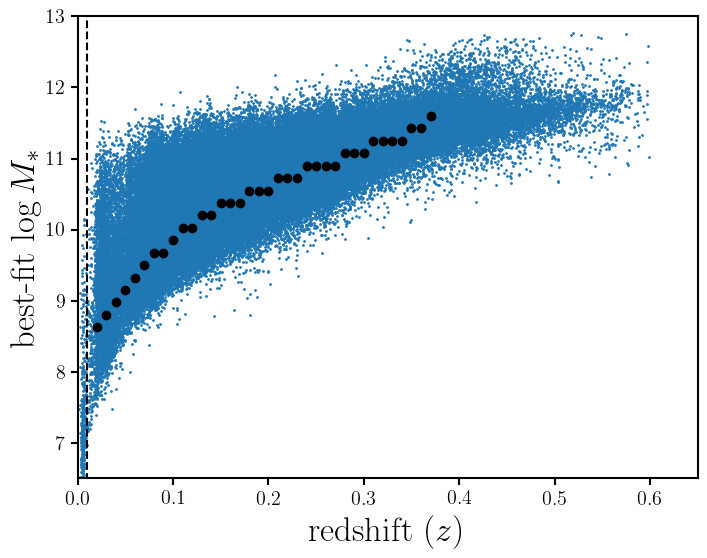

In [10]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['Z_HP'].data, np.median(bgs['provabgs_logMstar'].data,axis=1), c='C0', s=1)
sub.plot([0.01, 0.01], [6, 13.], c='k', ls='--')
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.65)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=25)
sub.scatter(zmlims[:36], mlims, color='black')
sub.set_ylim(6.5, 13.)

In [11]:
# Gathering data
z_tot = bgs['Z_HP'].data
x_tot = bgs['provabgs_logMstar'].data
x_median_tot = np.median(x_tot, axis=1)
w_zfail_tot = bgs['provabgs_w_zfail'].data
w_fib_tot = bgs['provabgs_w_fibassign'].data
vmax_tot = bgs['Vmax'].data

# Mass completeness limit
mlim_dict = {0:8.975, 1:9.500, 2:10.20, 3:10.38, 4:10.72, 5:10.89, 6:11.08, 7:11.42}

f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
zmins = [0.01 + 0.04 * i for i in range(7)]
zmaxs = [0.01 + 0.04 * (i+1) for i in range(7)]

0.01 - 0.05 galaxies:  3498
0.05 - 0.09 galaxies:  9139
0.09 - 0.13 galaxies:  8308
0.13 - 0.17 galaxies:  12569
0.17 - 0.21000000000000002 galaxies:  9195
0.21000000000000002 - 0.25 galaxies:  8664
0.25 - 0.29000000000000004 galaxies:  7504


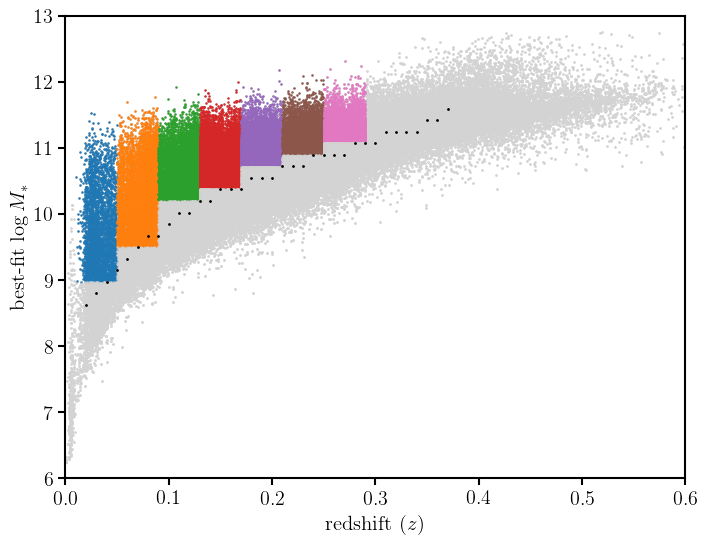

In [12]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

count_bin = 0 
sub.scatter(bgs['Z_HP'].data, np.median(bgs['provabgs_logMstar'].data,axis=1), c='lightgrey', s=1)
for zmin, zmax in zip(zmins,zmaxs):
    
    zlim_up = (z_tot > zmin) & (z_tot < zmax) & (w_zfail_tot > 0) & (x_median_tot > mlim_dict[count_bin])
    zlim_down = (z_tot > zmin) & (z_tot < zmax) & (w_zfail_tot > 0) & (x_median_tot < mlim_dict[count_bin])
    
    sub.scatter(z_tot[zlim_up], x_median_tot[zlim_up], s=0.5)
    sub.scatter(z_tot[zlim_down], x_median_tot[zlim_down], s=0.5, alpha=0.5, color='lightgrey')


#     sub.legend(loc='lower right', handletextpad=0.1)
    sub.set_xlabel(r"redshift ($z$)", fontsize=15)
    sub.set_xlim(0., 0.6)
    sub.set_ylabel(r"best-fit $\log M_*$", fontsize=15)
    sub.set_ylim(6., 13.)
    

#     plt.plot(np.linspace(zmin,zmax, 100), np.repeat(mlim_dict[count_bin], 100), color='black', alpha=0.6)
    count_bin+=1
    print(f'{zmin} - {zmax} galaxies: ', np.sum(zlim_up))
sub.scatter(zmlims[:36], mlims, color='black', s=1)

In [13]:
z0 = 0.01
dz = 0.04
for i in range(15): 
    print('%.2f < z < %.2f: %i' % (z0 + dz * i, z0 + dz * (i+1), np.sum((bgs['Z_HP'] > z0 + dz * i) & (bgs['Z_HP'] < z0 + dz * (i+1)))))

0.01 < z < 0.05: 5628
0.05 < z < 0.09: 12629
0.09 < z < 0.13: 15406
0.13 < z < 0.17: 21246
0.17 < z < 0.21: 19811
0.21 < z < 0.25: 18953
0.25 < z < 0.29: 18779
0.29 < z < 0.33: 11949
0.33 < z < 0.37: 7736
0.37 < z < 0.41: 5014
0.41 < z < 0.45: 3108
0.45 < z < 0.49: 1362
0.49 < z < 0.53: 659
0.53 < z < 0.57: 271
0.57 < z < 0.61: 66


(0.0, 0.65)

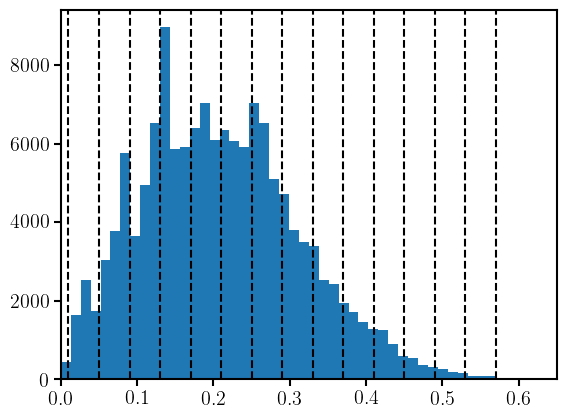

In [14]:
plt.hist(bgs['Z_HP'].data, range=(0., 0.65), bins=50)
for i in range(15):
    plt.axvline(z0+dz*i, color='k', linestyle='--')
plt.xlim(0.00, 0.65)

$z_0 = 0.01$ and $\Delta z = 0.04$ seem sensible.

# calculate $M_{\rm lim}$

In [15]:
m_nmf = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [16]:
r_pass = specFilter.load_filters('decam2014-r')

def r_mag(w, f):
    ''' calculate r-band magnitude given w, f
    '''
    flux_z, w_z = r_pass.pad_spectrum(np.atleast_2d(f) * 1e-17*U.erg/U.s/U.cm**2/U.Angstrom, w * U.Angstrom)
    maggies = r_pass.get_ab_maggies(flux_z, wavelength=w_z)
    return 22.5 - 2.5 * np.log10(maggies.as_array()[0][0] * 1e9)

In [17]:
def select_z_dz(thetas, zreds, dz=0.025): 
    ''' determine whether (theta, zred) galaxies would be within the sample if redshift
    was increased to zred + dz.
    '''
    dlzs0 = Planck13.luminosity_distance(zreds).to(U.cm).value
    dlzs1 = Planck13.luminosity_distance(zreds + dz).to(U.cm).value

    rmags = [] 
    for theta, zred, dlz0, dlz1 in zip(thetas, zreds, dlzs0, dlzs1): 
        w0, f0 = m_nmf.sed(theta[:-1], zred)

        w1 = w0 / (1 + zred) * (1 + zred + dz)
        f1 = f0 * (dlz0**2 / dlz1**2) * (1 + zred)/(1 + zred + dz)

        rmags.append(r_mag(w1, f1))
    rmags = np.array(rmags)
    return rmags < 19.5

In [19]:
bgs[:5]

RA,DEC,Z_HP,is_bgs_bright,is_bgs_faint,provabgs_logMstar [100],provabgs_avgSFR1Gyr_mcmc [100],Vmax,provabgs_w_zfail,provabgs_w_fibassign
float64,float64,float64,bool,bool,float64,float64,float64,float64,float64
191.14757099005186,60.345815959235,0.2819459922463374,True,False,10.848259925842285 .. 10.952618598937988,2.817000574672944 .. 3.214945747252959,9252931.015727047,1.0369954283580962,3.0714285714285716
187.05117249536465,62.614542270156655,0.2703579310142208,True,False,10.877055168151855 .. 10.874772071838379,0.05493949471383528 .. 0.03751695024942044,8649619.823054517,1.0018031916676053,1.0
187.83760708675698,60.38987543677365,0.1731108191825362,True,False,10.239782333374023 .. 10.281316757202148,2.396931118709436 .. 1.2811244075608916,4260209.668506557,1.029546314947554,1.8169014084507042
188.7298325265811,60.181046704454054,0.2854181586411897,True,False,10.893733024597168 .. 11.032293319702148,3.7291115057766393 .. 4.475181611034076,13304626.326162143,1.0090948854283563,3.6857142857142855
187.04622815471808,60.82670180284912,0.37400455377945924,True,False,11.330133438110352 .. 11.413797378540039,1.9892817047410054 .. 1.8418575154734729,19941784.969088297,1.0227117428257106,1.0


In [18]:
z0 = 0.01
dz = 0.02

zmins = np.array([z0 + iz * dz  for iz in range(16)])
zmaxs = zmins+dz

Mlims = []
for iz in range(16): 
    print('%.3f < z < %.3f' % (zmins[iz], zmaxs[iz]))
    zlim0 = (bgs['Z_HP'].data > zmins[iz]) & (bgs['Z_HP'].data < zmaxs[iz])

    in_zlim1 = select_z_dz(bgs['provabgs_theta_bf'].data[zlim0], bgs['Z_HP'].data[zlim0], dz=dz)

    h0, edges = np.histogram(bgs['provabgs_logMstar_bf'].data[zlim0], range=(6, 13), bins=40)
    h1, _ = np.histogram(bgs['provabgs_logMstar_bf'].data[zlim0][in_zlim1], range=(6, 13), bins=40)

    fcomp = (h1/h0)
    Mlim = (np.min(edges[:-1][(fcomp > 0.9) & (h0 > 5)]))

    _ = plt.hist(bgs['provabgs_logMstar_bf'].data[zlim0], 
                 range=(6, 13), bins=40, histtype='step', linewidth=2)
    _ = plt.hist(bgs['provabgs_logMstar_bf'].data[zlim0][in_zlim1], 
                 range=(6, 13), bins=40, histtype='step', linewidth=2)
    plt.axvline(Mlim, color='k', linestyle='--') 
    
    ymax = plt.gca().get_ylim()[1]
    plt.plot(0.5*(edges[1:] + edges[:-1])[h0 > 5], (h1/h0)[h0 > 5] * ymax, c='k')
    plt.plot([edges[0], edges[-1]], [ymax, ymax], c='k', ls=':')
    
    plt.xlim(7, 13)
    plt.show()
    
    Mlims.append(Mlim)

0.010 < z < 0.030


KeyError: 'provabgs_theta_bf'

save the following for demonstration purposes

In [ ]:
import pickle

In [ ]:
iz = 0
zlim0 = (bgs['Z_HP'].data > zmins[iz]) & (bgs['Z_HP'].data < zmaxs[iz])
in_zlim1 = select_z_dz(bgs['provabgs_theta_bf'].data[zlim0], bgs['Z_HP'].data[zlim0], dz=dz)

with open(os.path.join(dat_dir, 'ms_comp.bgs_bright.demo.p'), 'wb') as fp:
    pickle.dump([bgs['provabgs_logMstar_bf'].data[zlim0], in_zlim1], fp)

# save $\log M_*$ completeness limits to file 

In [ ]:
np.savetxt(os.path.join(dat_dir, 'psmf.logmstar_comp_limit.dat'), np.vstack([zmins, zmaxs, np.array([Mlims[0]] + Mlims)[:-1]]).T)